# Don't Overfit ！
数据来源：[Kaggle](https://www.kaggle.com/c/dont-overfit-ii/overview)

[数据下载](https://www.kaggle.com/c/dont-overfit-ii/data)

参考：
- [How to not overfit?](https://www.kaggle.com/artgor/how-to-not-overfit)

# 过程

In [7]:
## 加载需要的模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import lightgbm as lgb
import xgboost as xgb
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import linear_model

import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import json
import ast
import datetime
import time
import eli5
from eli5.sklearn import PermutationImportance
#import shap

#from mlxtend.feature_selection import SequentialFeatureSelector as SFS
#from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from catboost import CatBoostClassifier

C:\Users\stwan\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192



In [8]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.shape  ## 训练集大小

(250, 302)

In [9]:
train.head().append(train.tail())  ## 查看训练集前5行和最后5行
## 有300个特征

,id,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,...,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-1.067,-1.114,-0.616,0.376,1.090,0.467,-0.422,0.460,-0.443,-0.338,0.416,-2.177,-0.326,0.340,1.174,-0.245,-1.070,-0.336,-0.502,0.403,-0.605,-0.280,-1.618,0.878,-0.272,0.870,2.171,-0.214,0.477,-2.092,0.835,0.621,-2.810,1.029,-0.736,0.582,-0.079,0.493,1.359,-0.177,0.406,-0.163,1.341,0.754,0.491,-1.560,-0.520,0.766,0.216,-0.510,0.101,-0.602,-0.721,-0.545,1.564,2.003,-1.940,1.285,...,-1.037,0.513,0.694,0.856,-0.523,0.596,0.971,0.279,2.684,-0.057,-1.754,0.297,-2.196,0.798,-0.533,-0.661,0.564,-2.400,0.945,-0.971,0.055,1.107,-0.848,-1.781,0.254,-0.515,0.234,0.296,-1.774,2.032,-0.442,-0.116,1.393,-0.494,-0.179,1.874,1.463,-1.397,0.284,0.336,0.551,0.557,-0.522,-0.503,-0.541,1.393,0.506,-1.420,-0.123,-1.833,0.220,-0.339,0.254,-0.179,0.352,0.125,0.347,0.436,0.958,-0.824
1,1,0.0,-0.831,0.271,1.716,1.096,1.731,-0.197,1.904,-0.265,0.557,1.202,0.542,0.424,-1.572,-0.968,-1.483,0.564,0.047,-0.324,-1.490,0.179,-0.524,0.250,2.462,0.029,-1.399,-2.370,-1.505,-1.294,0.106,-0.145,0.235,-1.045,1.335,1.254,-0.811,1.812,0.181,-0.020,1.125,0.279,-0.682,1.161,1.194,0.243,1.179,1.338,-1.000,-0.362,-0.605,1.917,-1.157,0.394,-0.482,1.591,0.106,-0.959,0.600,-1.147,...,0.717,0.962,0.945,1.275,-0.879,0.372,0.965,0.610,-0.647,0.116,-1.935,-1.365,-1.609,-0.119,-0.690,-0.239,0.919,0.182,-0.203,-1.034,0.627,-1.472,0.496,-0.052,0.322,-0.222,1.168,0.931,-0.203,0.321,0.761,1.752,0.181,-3.029,-0.578,-0.260,-0.425,-0.160,-0.497,-0.049,1.097,0.398,0.554,0.578,-0.544,0.441,-0.524,-1.474,-0.090,-0.607,-0.765,-0.735,-1.158,2.554,0.856,-1.506,0.462,-0.029,-1.932,-0.343
2,2,0.0,0.099,1.390,-0.732,-1.065,0.005,-0.081,-1.450,0.317,-0.624,-0.017,-0.665,1.905,0.376,-1.373,1.587,1.464,-1.550,-0.512,0.508,-0.094,-0.114,-0.425,0.104,0.643,-1.371,1.553,-0.062,-0.173,-0.465,-1.252,0.443,2.205,-1.266,-0.739,0.827,-1.306,0.274,-1.573,-2.011,-1.228,-1.588,-0.825,-0.259,1.461,-1.751,-0.054,-0.026,-0.511,0.412,-0.150,2.040,-0.567,-0.177,-0.882,-0.337,0.785,-0.705,0.600,...,0.026,1.004,1.277,1.131,0.144,0.817,0.600,0.910,-0.757,-0.108,0.218,1.675,-1.223,0.206,2.153,0.257,1.761,0.848,-0.960,1.468,-1.610,-0.801,1.557,0.628,-0.072,-0.573,0.507,-1.229,0.313,1.446,-0.345,1.147,-0.623,-0.048,1.456,-0.932,0.666,0.451,0.671,-0.596,-0.135,0.966,-0.167,0.530,-1.493,-0.917,0.120,0.258,-0.405,-0.859,-1.311,0.799,-1.001,1.544,0.575,-0.309,-0.339,-0.148,-0.646,0.725
3,3,1.0,-0.989,-0.916,-1.343,0.145,0.543,0.636,1.127,0.189,-0.118,-0.638,0.760,-0.360,-2.048,-0.996,-0.361,0.962,0.021,0.595,-0.943,0.069,0.483,-0.063,-0.540,-0.551,-1.736,-2.014,0.636,-1.147,-0.767,-0.678,0.815,1.696,-0.436,-1.777,0.548,0.318,0.978,1.299,-0.540,0.248,1.791,-1.150,0.875,0.957,-1.859,0.000,-2.028,-0.315,-0.339,1.073,-1.278,0.084,0.020,-1.802,-2.193,-0.450,0.426,1.576,...,0.730,-1.140,0.546,0.629,-0.689,-1.421,-0.895,-0.734,-0.069,-1.502,1.384,-0.260,1.857,-0.319,-0.457,2.215,0.321,0.601,0.131,-1.137,0.011,1.137,0.499,-0.262,-1.484,0.216,-2.536,0.191,-0.142,1.387,-1.617,-0.662,-2.288,-1.130,0.651,-0.363,0.686,-0.504,1.734,-0.606,0.514,-0.506,-1.294,0.382,-1.119,1.695,-0.775,-1.428,0.231,-0.780,-1.370,1.093,0.596,-0.589,-0.649,-0.163,-0.958,-1.081,0.805,3.401
4,4,0.0,0.811,-1.509,0.522,-0.360,-0.220,-0.959,0.334,-0.566,-0.656,-0.499,-0.653,-0.058,-0.046,0.654,-0.697,-1.175,0.720,0.484,0.402,-1.037,1.081,0.716,-0.144,1.720,-1.980,-0.741,-1.493,-0.860,-0.082,0.133,1.084,-0.719,0.198,1.144,1.123,0.435,-0.296,-2.933,0.831,1.905,0.485,0.490,-0.199,-0.269,1.141,0.007,2.126,-0.049,0.699,1.877,-0.658,0.410,-0.426,-0.854,1.443,-0.560,0.993,-0.256,...,-0.077,-1.009,-0.138,-0.260,-0.903,0.347,-1.098,-1.027,-0.882,-0.110,

Text(0.5, 1.0, 'Distribution of Stds of all columns')

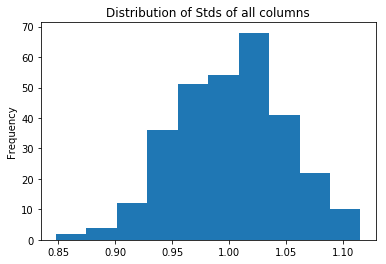

In [10]:
train[train.columns[2:]].std().plot('hist')  ## 300个特征的标准差的分布直方图
plt.title('Distribution of Stds of all columns')

Text(0.5, 1.0, 'Distribution of Means of all columns')

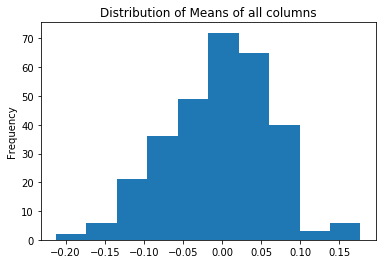

In [11]:
train[train.columns[2:]].mean().plot('hist')  ## 300个特征的均值的分布直方图
plt.title('Distribution of Means of all columns')

In [12]:
## 查看数据缺失情况
train.isnull().any().any()
## 无缺失

False

Distributions of first 28 columns


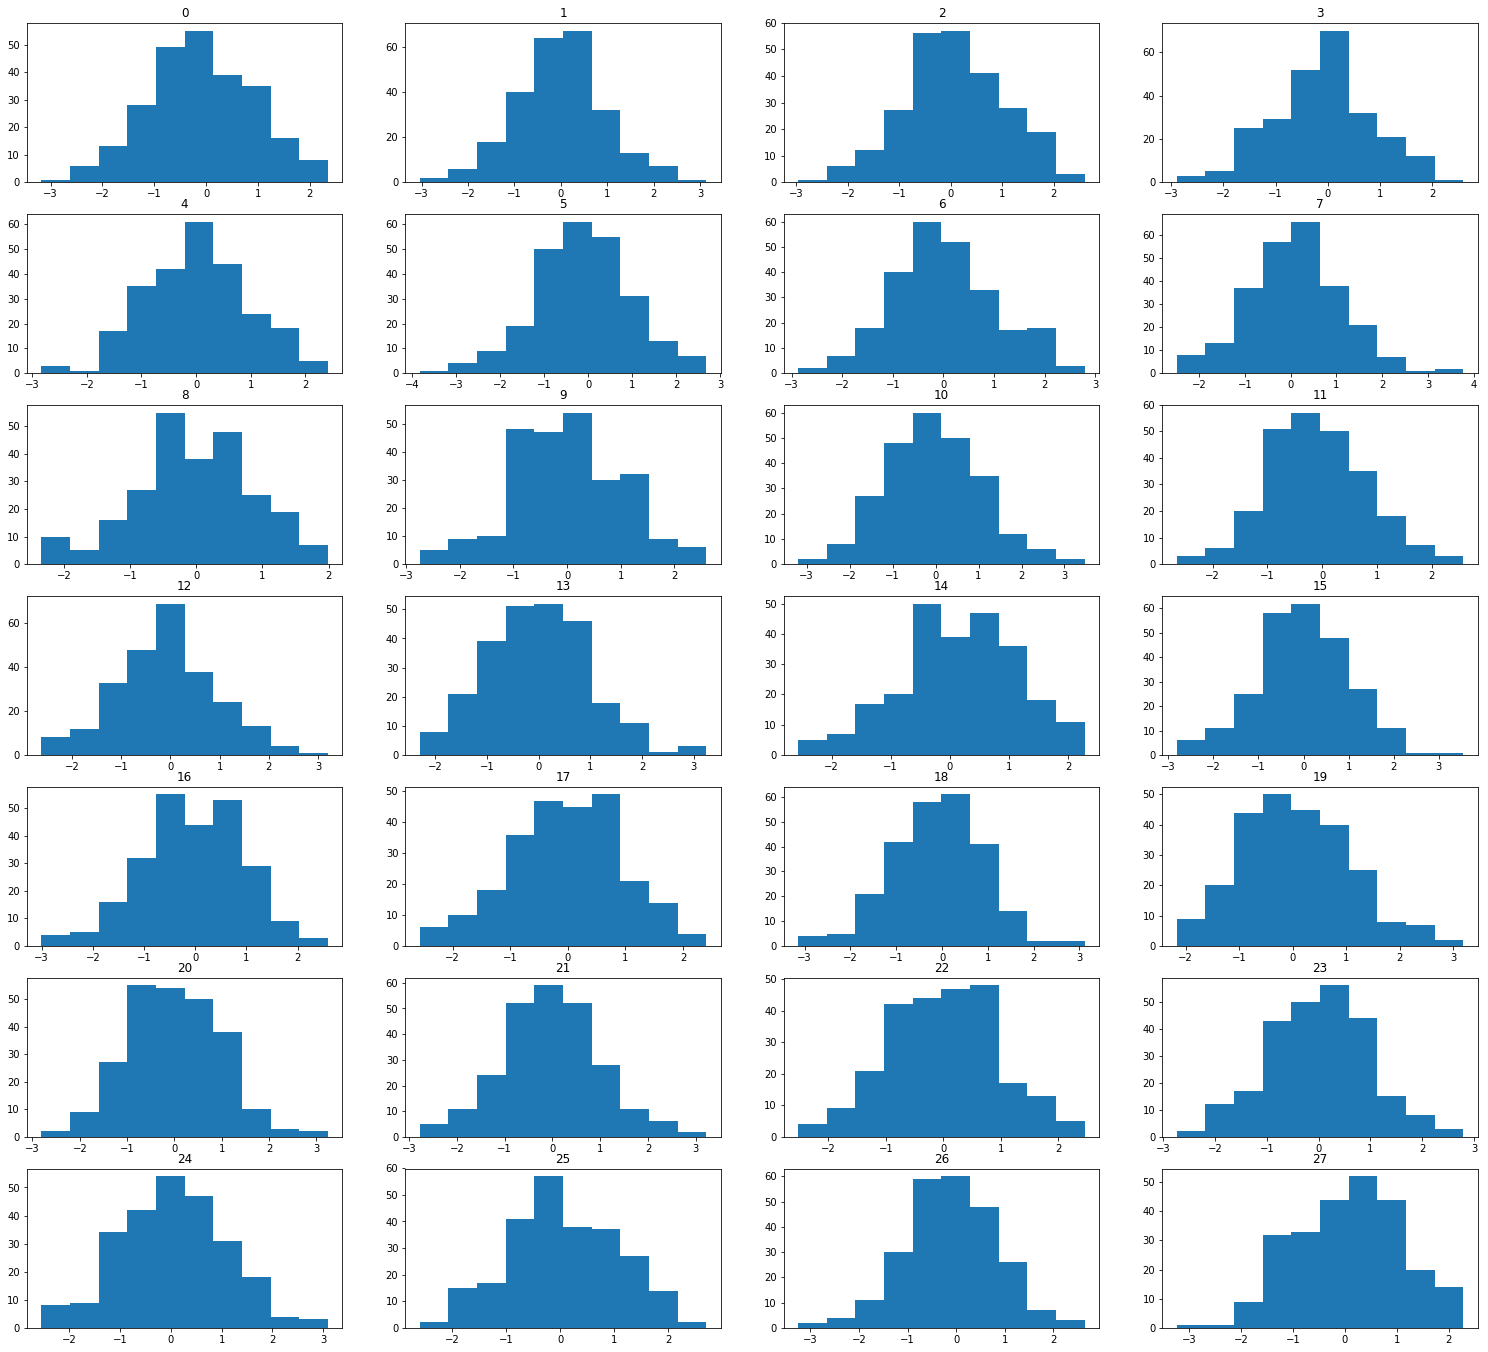

In [13]:
## 可视化前28个特征
print('Distributions of first 28 columns')
plt.figure(figsize=(26, 24))  ## 画布大小
for i, col in enumerate(list(train.columns)[2:30]):
    plt.subplot(7, 4, i + 1)  ## 将画布分为7行4列，画在第i+1个位置
    plt.hist(train[col])
    plt.title(col)

In [14]:
## 查看标签的分布情况
train['target'].value_counts()

0.0    183
1.0     67
Name: target, dtype: int64

- 二分类

- 有183个0和67个1，数据不平衡

- 不同列的值的分布较为相似

- 列的标准差集中分布在1附近

- 列的均值集中分布在0附近

In [15]:
## 查看列之间的相关性
corrs = train.corr().abs().unstack().sort_values(kind='quicksort').reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(10)  ## 列出相关性最强的10对

,level_0,level_1,0
90892,219,279,0.238512
90893,279,219,0.238512
90894,23,20,0.246984
90895,20,23,0.246984
90896,146,228,0.258447
90897,228,146,0.258447
90898,6,39,0.267727
90899,39,6,0.267727
90900,127,target,0.337540
90901,target,127,0.337540


In [16]:
X_train = train.drop(['id', 'target'], axis=1)  ## 训练特征集
y_train = train['target']
X_test = test.drop(['id'], axis=1)
n_fold = 20
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=20, n_repeats=20, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  ## 标准化
X_test = scaler.transform(X_test)  ## 按X_train构造的标准化器标准化测试集特征

In [ ]:
## 逻辑回归
model_lr = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
